# Heart Disease Prediction using simple Neural Network model

In [1]:
import numpy as np
import mlflow
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [20]:
print(tf.__version__)

2.12.0


In [2]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

In [3]:
data = pd.read_csv("heart.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
#data = data.drop(columns=["target"])
#data.head()

In [5]:
train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

193 train examples
49 validation examples
61 test examples


In [6]:
train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
133,41,1,1,110,235,0,1,153,0,0.0,2,0,2,1
186,60,1,0,130,253,0,1,144,1,1.4,2,1,3,0
223,56,0,0,200,288,1,0,133,1,4.0,0,2,3,0
245,48,1,0,124,274,0,0,166,0,0.5,1,0,3,0
91,57,1,0,132,207,0,1,168,1,0.0,2,0,3,1


In [7]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [8]:
df_to_dataset(data)

<_BatchDataset element_spec=({'age': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sex': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'cp': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'trestbps': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'chol': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'fbs': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'restecg': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'thalach': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'exang': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'oldpeak': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'slope': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'ca': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'thal': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [9]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [10]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['age'])
    print('A batch of targets:', label_batch )

Every feature: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
A batch of ages: tf.Tensor([56 49 55 60 56], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([1 0 1 1 0], shape=(5,), dtype=int64)


In [11]:
example_batch = next(iter(train_ds))[0]
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

In [12]:
photo_count = feature_column.numeric_column('age')
demo(photo_count)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
[[45.]
 [58.]
 [43.]
 [62.]
 [45.]]


In [13]:
age = feature_column.numeric_column('age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 3, 5])
demo(age_buckets)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [14]:
feature_columns = []

# numeric cols
for header in ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"]:
    feature_columns.append(feature_column.numeric_column(header))

In [15]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [16]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [17]:
mlflow.tensorflow.autolog(every_n_iter=2)

In [18]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=40)

2023/06/27 21:29:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ada9384801824a9cbd0ee5dcb3f208d0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2023/06/27 21:29:50 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/06/27 21:29:50 WARNING mlflow.data.tensorflow_dataset: Failed to infer schema for TensorFlow dataset. Exception: Failed to infer schema for tf.data.Dataset. Schemas can only be inferred if the dataset consists of tensors. Ragged tensors, tensor arrays, and other types are not supported. Additionally, datasets with nested tensors are not supported.
2023/06/27 21:29:50 WARNING mlflow.data.tensorflow_dataset: Failed to infer schema for TensorFlow dataset. Exception: Failed to infer schema for tf.data.Dataset. Schemas can only be inferred if the dat

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


2023/06/27 21:29:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\pedro\OneDrive\Escritorio\Proyecto_IA_SS\venv\lib\site-packages\mlflow\tensorflow\_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Epoch 1/40
7/7 [==============================] - 4s 149ms/step - loss: 5.6889 - accuracy: 0.4456 - val_loss: 3.0085 - val_accuracy: 0.5306
Epoch 2/40
7/7 [==============================] - 0s 20ms/step - loss: 3.1831 - accuracy: 0.4715 - val_loss: 1.7852 - val_accuracy: 0.5102
Epoch 3/40
7/7 [==============================] - 0s 23ms/step - loss: 3.6313 - accuracy: 0.4819 - val_loss: 0.9068 - val_accuracy: 0.6735
Epoch 4/40
7/7 [==============================] - 0s 19ms/step - loss: 2.2418 - accuracy: 0.5855 - val_loss: 0.7911 - val_accuracy: 0.7551
Epoch 5/40
7/7 [==============================] - 0s 23ms/step - loss: 2.5450 - accuracy: 0.5544 - val_loss: 1.1874 - val_accuracy: 0.6327
Epoch 6/40
7/7 [==============================] - 0s 18ms/step - loss: 2.0156 - accuracy: 0.6114 - val_loss: 0.8439 - val_accuracy: 0.7143
Epoch 7/40
7/7 [==============================] - 0s 25ms/step - loss: 1.8876 - accuracy: 0.6580 - val_loss: 0.9113 - val_accuracy: 0.6735
Epoch 8/40
7/7 [==========

7/7 [==============================] - 0s 26ms/step - loss: 0.7260 - accuracy: 0.6477 - val_loss: 0.9629 - val_accuracy: 0.6327
Epoch 36/40
7/7 [==============================] - 0s 18ms/step - loss: 0.9031 - accuracy: 0.6891 - val_loss: 0.7393 - val_accuracy: 0.6531
Epoch 37/40
7/7 [==============================] - 0s 23ms/step - loss: 0.9140 - accuracy: 0.6166 - val_loss: 1.0348 - val_accuracy: 0.6327
Epoch 38/40
7/7 [==============================] - 0s 20ms/step - loss: 0.9245 - accuracy: 0.7098 - val_loss: 0.5938 - val_accuracy: 0.6735
Epoch 39/40
7/7 [==============================] - 0s 22ms/step - loss: 0.7815 - accuracy: 0.6218 - val_loss: 0.9079 - val_accuracy: 0.6327
Epoch 40/40
1/1 [==============================] - 1s 665ms/step


INFO:tensorflow:Assets written to: C:\Users\pedro\AppData\Local\Temp\tmp7e184msk\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\pedro\AppData\Local\Temp\tmp7e184msk\model\data\model\assets
2023/06/27 21:30:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\pedro\OneDrive\Escritorio\Proyecto_IA_SS\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


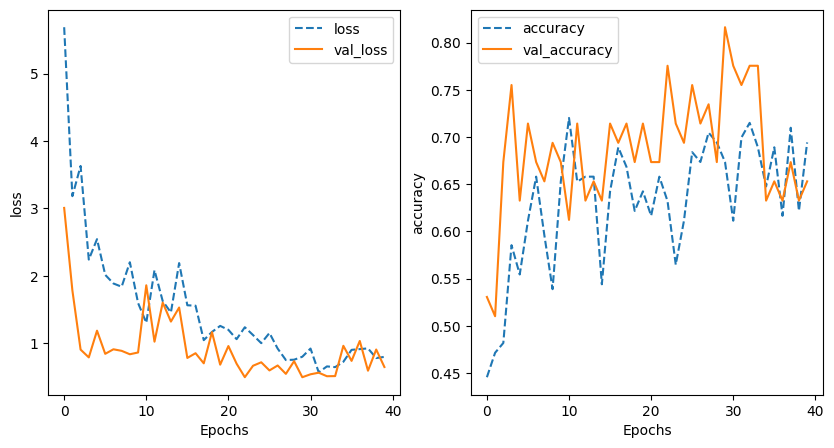

In [19]:
training_plot(['loss','accuracy'], history)